In [3]:
#import karateclub

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
#import karateclub
#from sklearn.manifold import TSNE
#import networkx as nx
from rdkit import Chem
#from rdkit.Chem import AllChem
#from sklearn.metrics import roc_auc_score,make_scorer
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

In [4]:
import os
import matplotlib.pyplot as plt

In [5]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [16]:
genetox_outcomes = pd.read_csv(raw_dir/'genetox_outcomes.csv',index_col=0)
genetox_outcomes

,DTXSID,outcome,SMILES
0,DTXSID00148597,1,ClCC1=C2C=CC3=CC=CC4=C3C2=C(C=C1)C=C4
1,DTXSID00157169,1,CCNC1=C(O)C(Cl)=CC(=C1)[N+]([O-])=O
2,DTXSID00159204,0,CCO[Si](C)(CCCCl)OCC
3,DTXSID00160734,0,NCCCC(O)(P(O)(O)=O)P(O)(O)=O
4,DTXSID00162834,0,CNCC1=CC=CC2=CC=CC=C12
...,...,...,...
5398,DTXSID90890477,0,COC1=C(NC2=NC(SCCCS(O)(=O)=O)=NC(SCCCS(O)(=O)=...
5399,DTXSID90890619,0,OC(=O)C1=C(C=CC=C1)N=NC1=C2C=CC=CC2=CC=C1O
5400,DTXSID90890811,0,CCCCCCCCCC1=CC2=CC=CC=C2C(=C1CCCCCCCCC)S(O)(=O)=O
5401,DTXSID90891080,0,CC1=C(Cl)C=C(N=NC2=C(O)C=CC3=CC=CC=C23)C(=C1)S...


In [17]:

smile_outcome_dict = dict(zip(list(genetox_outcomes.SMILES),list(genetox_outcomes.outcome)))

In [18]:
gentox_dict = {k:v for k,v in zip(genetox_outcomes['DTXSID'], genetox_outcomes['outcome'])}

In [19]:
fps = []
for smile in list(smile_outcome_dict.keys()):
    mol = Chem.MolFromSmiles(smile)
    fps.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol,3,2048)))

X_fps = np.array(fps)
y = list(smile_outcome_dict.values())

knn = KNeighborsClassifier(n_jobs=-1)
cv = cross_validate(knn,X_fps,y,cv=5,scoring=make_scorer(roc_auc_score))

[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerator
[17:43:15] DEPRECATION WARNING: please use MorganGenerat

In [20]:
print(cv['test_score'].mean())

0.6650191738817537


In [21]:
lr = LogisticRegression(n_jobs=-1)
cv = cross_validate(lr,X_fps,y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
print(cv['test_score'].mean())

0.7315262889742372


In [22]:
def smile_to_mol_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    g = nx.Graph()
    
    # Add nodes with atom properties
    for atom in mol.GetAtoms():
        node_label = {
    "symbol": atom.GetSymbol(),
    "degree": atom.GetDegree(),
    "hybridization": str(atom.GetHybridization()),
    "aromaticity": atom.GetIsAromatic(),
    "formal_charge": atom.GetFormalCharge(),
    "implicit_hydrogen_count": atom.GetTotalNumHs()
}
        g.add_node(atom.GetIdx(), atom_label = str(node_label))

    # Add edges with bond properties
    for bond in mol.GetBonds():
        g.add_edge(bond.GetBeginAtomIdx(), 
                   bond.GetEndAtomIdx(), 
                   bond_type=str(bond.GetBondType()))

    return g

In [23]:
graphs = {k:smile_to_mol_graph(v) for k,v in zip(genetox_outcomes['DTXSID'], genetox_outcomes['SMILES'])}

In [24]:
mydict =  {k:v for k,v in zip(genetox_outcomes['DTXSID'], genetox_outcomes['SMILES'])}

In [25]:
model_dict = {'ldp': karateclub.LDP(), 'gl2': karateclub.GL2Vec(), 'graph2vec':karateclub.Graph2Vec(attributed=True)}



In [26]:
def mol_embed(model, graphs):
    # Ensure all graphs are attributed properly
    for graph in graphs:
        for node in graph.nodes():
            if "feature" not in graph.nodes[node]:
                graph.nodes[node]["feature"] = "default"

    # Ensure all graphs have integer labels
    graphs = [nx.convert_node_labels_to_integers(g) for g in graphs]
    
    # Remove empty graphs
    graphs = [g for g in graphs if len(g.nodes) > 0]

    # Fit the model
    model.fit(graphs)
    X_embedding = model.get_embedding()

    # Perform t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    z = tsne.fit_transform(X_embedding)
    return z, X_embedding


In [27]:
results = {}
for k,v  in model_dict.items():
    results[k] = mol_embed(v, list(graphs.values()))

In [28]:
from sklearn.preprocessing import minmax_scale,StandardScaler
from scipy.spatial.distance import pdist,squareform

In [29]:
results['ldp'][0].shape

(5403, 2)

In [30]:
pd.DataFrame(list(gentox_dict.items()), columns = ['dtxsid', 'outcome']).set_index('dtxsid')

,outcome
dtxsid,
DTXSID00148597,1
DTXSID00157169,1
DTXSID00159204,0
DTXSID00160734,0
DTXSID00162834,0
...,...
DTXSID90890477,0
DTXSID90890619,0
DTXSID90890811,0


In [31]:
mydfs = []
for k, v in results.items():
    df = pd.DataFrame(v[0], columns = ['comp_1', 'comp_2'],index =mydict.keys() )
    df['approach'] = k
    df2 = pd.DataFrame(list(gentox_dict.items()), columns = ['dtxsid', 'outcome']).set_index('dtxsid')
    df = pd.concat([df,df2], axis =1)
    mydfs.append(df)

In [54]:
mydfs[2].to_csv(external_dir/'graph2vec_genotox.csv')

Reloaded dataset as dependency conflicts with karateclub, seaborn and matplotlib

In [34]:
df = pd.read_csv(external_dir/'graph2vec_genotox.csv', index_col = [0])

In [35]:
df

,comp_1,comp_2,approach,outcome
DTXSID00148597,11.317873,-5.160870,graph2vec,1
DTXSID00157169,16.510847,4.615251,graph2vec,1
DTXSID00159204,-32.353775,10.324084,graph2vec,0
DTXSID00160734,-77.320780,-4.804577,graph2vec,0
DTXSID00162834,47.798183,-4.512435,graph2vec,0
...,...,...,...,...
DTXSID90890477,-27.382622,-5.182812,graph2vec,0
DTXSID90890619,45.119370,-10.858923,graph2vec,0
DTXSID90890811,-34.425602,3.109055,graph2vec,0
DTXSID90891080,-5.829217,-11.570821,graph2vec,0


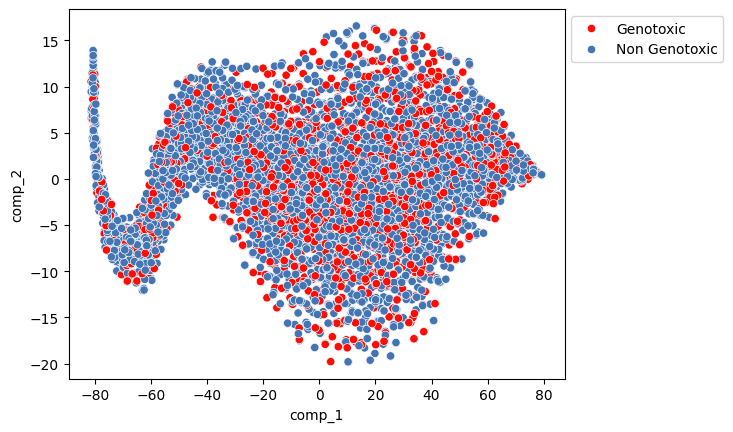

In [36]:
df['outcome'] = df['outcome'].apply(lambda x: 'Genotoxic' if x == 1 else 'Non Genotoxic' if x == 0 else 'Unknown')

colors = ["#FF0B04","#4374B3"]
sns.set_palette(sns.color_palette(colors))
ax =sns.scatterplot(x='comp_1',y='comp_2', hue='outcome', data=df)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(figures_dir/'Graph2Vec_030425.png', dpi = 300, bbox_inches='tight')


In [35]:
results['graph2vec'][1]

array([[ 0.045998  , -0.00824807, -0.04123961, ..., -0.01010982,
         0.00572475,  0.02415949],
       [ 0.04183851, -0.00712857, -0.05029991, ..., -0.01921966,
         0.00657908,  0.01760764],
       [ 0.05419705, -0.01858653, -0.06444436, ..., -0.02427631,
        -0.00444082,  0.02995869],
       ...,
       [ 0.04180409, -0.01811714, -0.04992862, ..., -0.01662297,
        -0.00029683,  0.02380295],
       [ 0.04185424, -0.0135689 , -0.04397656, ..., -0.02271942,
         0.00664125,  0.02066013],
       [ 0.03322152, -0.01260208, -0.03516565, ..., -0.02036975,
        -0.00080032,  0.01924143]], dtype=float32)

In [36]:
y = genetox_outcomes.outcome

In [37]:
knn = KNeighborsClassifier(n_jobs=-1)
cv = cross_validate(knn,results['graph2vec'][1],y,cv=5,scoring=make_scorer(roc_auc_score))
print(cv['test_score'].mean())

0.5163461017844362


In [38]:
lr = LogisticRegression(n_jobs=-1)
cv = cross_validate(lr,results['graph2vec'][1],y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
print(cv['test_score'].mean())

0.5482187721757409


In [50]:
y1 = y.copy()

In [53]:
for k, v in results.items():
    for model in [knn, lr]:
        if model == knn:
            cv = cross_validate(model,v[1],y1,cv=5,scoring=make_scorer(roc_auc_score))
            a = cv['test_score'].mean()
        else:
            cv = cross_validate(model,v[1],y1,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
            a = cv['test_score'].mean()
        print(k, a, model)

ldp 0.5850202413587179 KNeighborsClassifier(n_jobs=-1)


/home/grace/miniforge3/envs/metgraph/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/grace/miniforge3/envs/metgraph/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

ldp 0.6894711795430084 LogisticRegression(n_jobs=-1)
gl2 0.6090184677051477 KNeighborsClassifier(n_jobs=-1)
gl2 0.6671200046749004 LogisticRegression(n_jobs=-1)
graph2vec 0.5163461017844362 KNeighborsClassifier(n_jobs=-1)
graph2vec 0.5482187721757409 LogisticRegression(n_jobs=-1)
